In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

import torch
from torchvision import transforms

from adabound import AdaBound
from pipeline import Pipeline
from ResNetMNIST import ResNetMNIST
from MNISTpulse2percept import MNISTpulse2percept

<ipython-input-1-f98c314a0683>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [3]:
DATA_PATH              = os.path.join(os.getcwd(), 'data')
FULL_ARGUSII_DATA_PATH = os.path.join(DATA_PATH, 'MNIST', 'processed', 'AxonMapModel-ArgusII')

In [4]:
# get mean and std for the train data in order to normalize our data later
trainset      = MNISTpulse2percept(path=FULL_ARGUSII_DATA_PATH,
                                   transform=transforms.ToTensor())
trainloader   = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
trainset_mean = next(iter(trainloader))[0].mean(axis=(0, 2, 3))[0]
trainset_std  = next(iter(trainloader))[0].std( axis=(0, 2, 3))[0]
print(f' Trainset mean value for each channel is: {trainset_mean:.2f}')
print(f' Trainset std  value for each channel is: {trainset_std :.2f}')

 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20


In [5]:
transform   = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.repeat(3, 1, 1)), #grayscale to RGB
                                  transforms.Normalize(trainset_mean, trainset_std)])

trainset = MNISTpulse2percept(path=FULL_ARGUSII_DATA_PATH, train=True,  transform=transform)
testset  = MNISTpulse2percept(path=FULL_ARGUSII_DATA_PATH, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


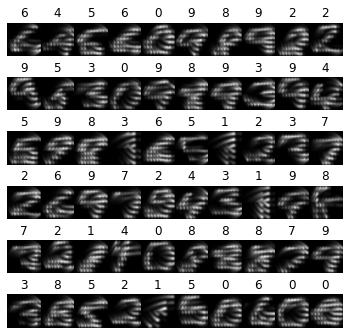

In [7]:
def min_max_scaling(img):
    return (img-img.min())/(img.max()-img.min())

fig = plt.figure(figsize=(6, 6))
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(min_max_scaling(np.transpose(images[index], (1, 2, 0))[:, :, 0]), cmap='gray')
    plt.title(int(labels[index].cpu()))
    plt.subplots_adjust(hspace=0, wspace=0)

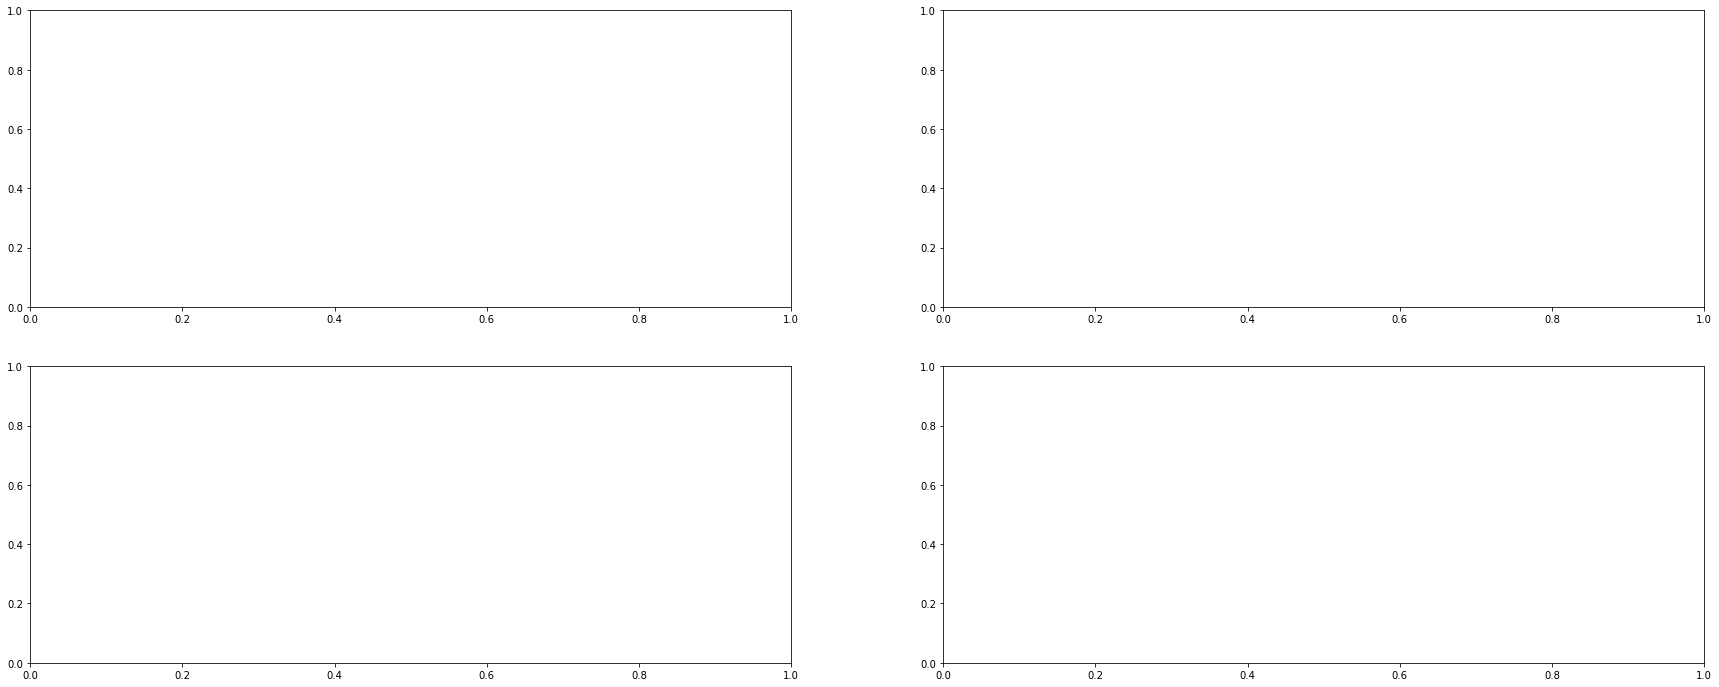

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_argusII = ResNetMNIST(pretrained=True,
                            feature_extraction=True,
                            load_state_path='./MNISTresNetModel_adabound.pth')

criterion = torch.nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems
optimizer = AdaBound(model_argusII.parameters(), lr=1e-3, final_lr=0.1)

ppln_argusII = Pipeline(model_argusII, device, optimizer, criterion,
                                 trainloader, testloader, testloader,
                                 live_plot=True)

In [9]:
_ = ppln_argusII.test()

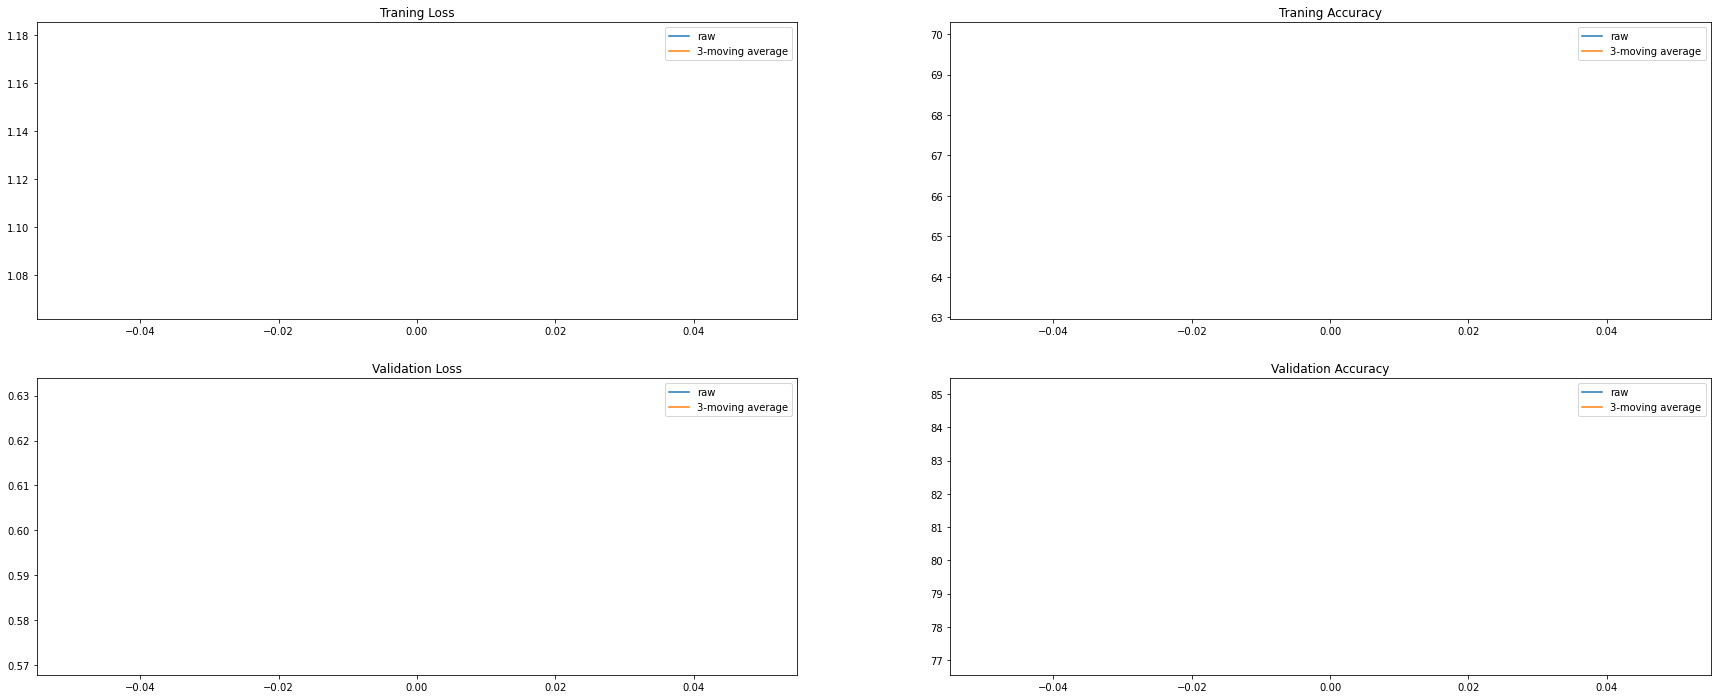

Training complete in 4m 50s
1 epochs done. Best validation accuracy is 81.020. Best validation loss is 0.601


([tensor(1.1234, device='cuda:0', grad_fn=<DivBackward0>)],
 [tensor(0.6008, device='cuda:0')],
 [66.6227550901299],
 [81.02],
 ResNetMNIST(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [10]:
ppln_argusII.training(epochs=1)

In [11]:
ppln_argusII.test(ppln_argusII.best_model)

(0.5984717011451721, 81.02)

In [12]:
# ppl_argusII.best_model.fc.weight.requires_grad = True
# ppl_argusII.best_model.fc.bias.requires_grad   = True
# i=0
# for param in ppl_argusII.best_model.parameters():
#     param.requires_grad=True
# sum(1 for param in ppl_argusII.best_model.parameters())

In [13]:
# # ppl_argusII.set_model(ppl_argusII.best_model)
# # set_parameter_requires_grad(ppl_argusII.best_model, True)
# # model_argusII.fc.weight.requires_grad = True
# # model_argusII.fc.bias.requires_grad   = True
# ppl_argusII.criterion = torch.nn.CrossEntropyLoss() # loss function - cross entropy works well for multi-class problems
# ppl_argusII.optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

# ppl_argusII.model.to(device)
# sum(1 for param in ppl_argusII.model.parameters() if param.requires_grad==True)

In [14]:
# set_parameter_requires_grad(model_argusII, True)
# model_argusII.fc.weight.requires_grad = True
# model_argusII.fc.bias.requires_grad   = True

In [15]:
# ppl_argusII.training(epochs=10)

In [16]:
torch.save(model_argusII.state_dict(), os.path.join(os.getcwd(), 'MNISTresNetModel_ARGUSII_1_epoch.pth'))